# TD learning en temps discret — 4 améliorations “naturelles” (notebook complet)

Ce notebook part d’un modèle TD simple (temps one-hot) et ajoute 4 améliorations :

1. **Bases temporelles** (features temporelles au lieu d’un état one-hot)  
2. **Approximation de fonction** (linéaire puis petit MLP, en NumPy)  
3. **Bruit / stochasticité** (reward-time variable, reward probabiliste)  
4. **Actor–Critic** (politique + valeur : le modèle décide)

Objectif : voir **où sont les poids**, **ce qui est appris**, et **ce que chaque amélioration change**.


In [109]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

def set_seed(seed=0):
    np.random.seed(seed)

def moving_average(x, w=5):
    x = np.asarray(x)
    if w <= 1:
        return x
    k = np.ones(w) / w
    return np.convolve(x, k, mode="same")


## 0) Baseline : TD tabulaire + “serial compound”

Temps discret `t=0..T-1`. Un état = un pas de temps (one-hot implicite).

Règle TD :
$\delta_t = r_t + \gamma V_{t+1} - V_t,\quad V_t \leftarrow V_t + \alpha \delta_t$

**Où sont les poids ?** Ici les poids sont **directement** le vecteur `V[t]` (un paramètre par temps).


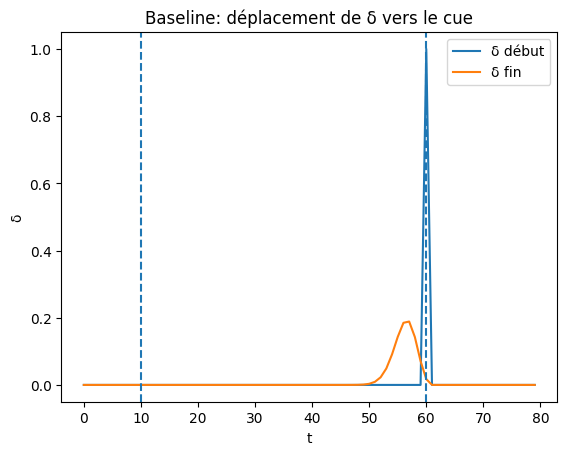

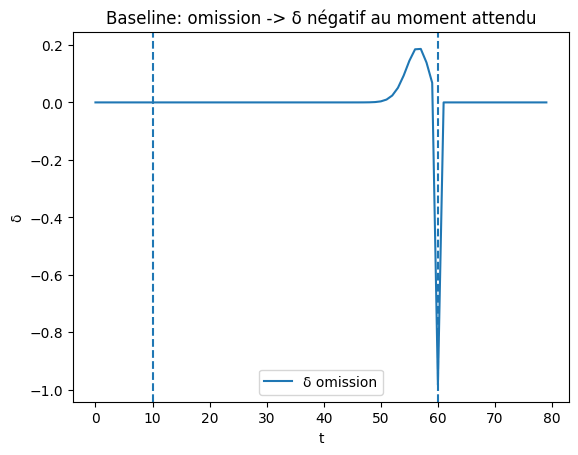

In [110]:
class TDTabularSerialCompound:
    """TD tabulaire: les poids sont V[t]."""
    def __init__(self, T=80, cue_time=10, reward_time=60, alpha=0.05, gamma=0.98):
        self.T = int(T)
        self.cue_time = int(cue_time)
        self.reward_time = int(reward_time)
        self.alpha = float(alpha)
        self.gamma = float(gamma)
        self.V = np.zeros(self.T, dtype=float)  # <-- poids tabulaires

    def run_trial(self, reward_delivered=True, reward_value=1.0):
        r = np.zeros(self.T, dtype=float)
        # Reward vector: only reward_time gets a non-zero value when delivered.
        if reward_delivered and 0 <= self.reward_time < self.T:
            r[self.reward_time] = reward_value

        deltas = np.zeros(self.T, dtype=float)
        V_trace = np.zeros(self.T, dtype=float)

        for t in range(self.T):
            Vt = self.V[t]
            Vtp1 = self.V[t+1] if t+1 < self.T else 0.0
            delta = r[t] + self.gamma * Vtp1 - Vt
            # TD error pushes value backward through time (bootstrapping on V_{t+1}).
            self.V[t] += self.alpha * delta  # <-- update des poids
            deltas[t] = delta
            V_trace[t] = self.V[t]
        return deltas, V_trace, r

def train(model, n_train=80, reward_value=1.0):
    D, V = [], []
    for _ in range(n_train):
        d, vt, _ = model.run_trial(True, reward_value)
        D.append(d); V.append(vt)
    return np.array(D), np.array(V)

# Démo baseline
model0 = TDTabularSerialCompound(T=80, cue_time=10, reward_time=60, alpha=0.05, gamma=0.98)
train_d0, train_V0 = train(model0, n_train=80)

omit_d0, _, _ = model0.run_trial(reward_delivered=False)

t = np.arange(model0.T)
# Courbe 1: δ recule du reward vers le cue au fil des essais.

plt.figure()
plt.plot(t, train_d0[0], label='δ début')
plt.plot(t, train_d0[-1], label='δ fin')
plt.axvline(model0.cue_time, linestyle='--')
plt.axvline(model0.reward_time, linestyle='--')
plt.xlabel('t'); plt.ylabel('δ'); plt.legend()
plt.title('Baseline: déplacement de δ vers le cue')
plt.show()

plt.figure()
plt.plot(t, omit_d0, label='δ omission')
plt.axvline(model0.cue_time, linestyle='--')
plt.axvline(model0.reward_time, linestyle='--')
plt.xlabel('t'); plt.ylabel('δ'); plt.legend()
plt.title('Baseline: omission -> δ négatif au moment attendu')
plt.show()


### Lecture des graphes (baseline)
<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
Modèle tabulaire: chaque pas de temps est un état one-hot et V[t] est le poids associé. On modélise le temps comme un vecteur discret pour voir clairement comment la règle TD (delta = r + gamma V[t+1] - V[t]) recule la prédiction vers le cue; gamma < 1 permet de propager la valeur en arrière sans explosion.
</div>
<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
Graphique 1 (δ début vs fin): au début, δ ne sort qu'à l'instant du reward. Après apprentissage, le pic positif migre vers le cue: la valeur anticipée est rétro-propagée dans le temps et encode la prédiction de reward dès le signal précurseur.
</div>
<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
Graphique 2 (omission): quand la récompense attendue n'est pas livrée, δ devient fortement négatif pile à l'instant prévu du reward. Cela montre que le modèle a internalisé une attente précise (V[t] élevé) et génère une pénalité quand cette attente est déçue.
</div>


## 1) Amélioration #1 — Bases temporelles

Les bases temporelles sont des fonctions gaussiennes qui se chevauchent, définies sur l'axe temporel. Elles permettent de représenter le temps de manière lissée et continue, contrairement à une représentation one-hot où chaque instant est indépendant. Chaque base est activée autour d'un centre temporel spécifique, avec une largeur contrôlée par un paramètre $\sigma$.

La forme générale d'une base gaussienne est donnée par :

$$
\phi_k(t) = \exp\left(-\frac{(t - \mu_k)^2}{2\sigma^2}\right)
$$

où :
- $ \mu_k $ est le centre de la base $ k $,
- $ \sigma $ contrôle la largeur de la base (plus $ \sigma $ est grand, plus la base est large),
- $ t $ est le temps discret.

Ces bases se chevauchent pour permettre une représentation continue et lisse du temps.

$V(t)=w^\top \phi(t)$

**Poids = `w`** (dimension $K \ll T$). Update :
$w \leftarrow w + \alpha\,\delta_t\,\phi(t)$


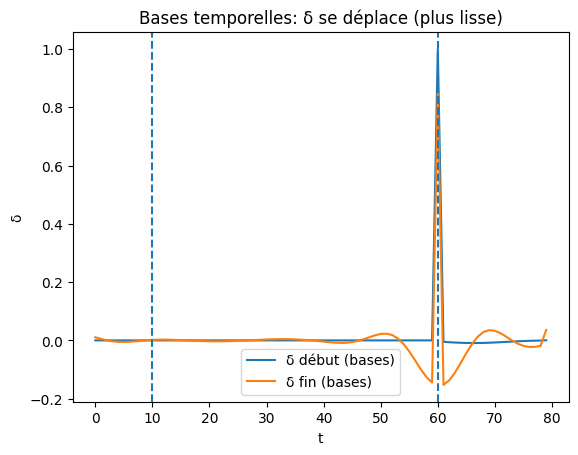

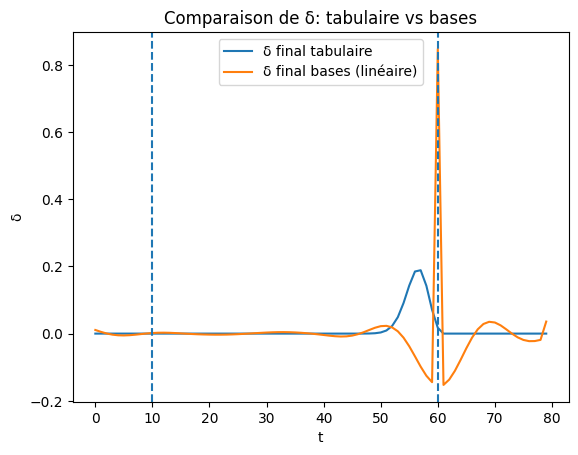

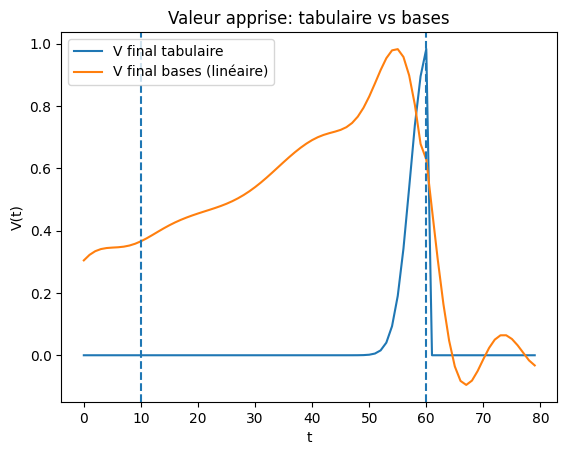

In [111]:
def gaussian_time_bases(T, K, sigma=5.0):
    t = np.arange(T)[:, None]
    centers = np.linspace(0, T-1, K)[None, :]
    Phi = np.exp(-0.5 * ((t - centers) / sigma)**2)
    # Bases gaussiennes qui se chevauchent pour partager la valeur sur plusieurs temps.
    Phi = Phi / (Phi.max(axis=0, keepdims=True) + 1e-12)
    # Normalisation colonne par colonne pour que chaque base ait la même échelle.
    return Phi

class TDLinearFeatures:
    """TD linéaire: V(t)=w^T phi(t)."""
    def __init__(self, Phi, reward_time=60, alpha=0.08, gamma=0.98):
        self.Phi = np.asarray(Phi)
        self.T, self.K = self.Phi.shape
        self.reward_time = int(reward_time)
        self.alpha = float(alpha)
        self.gamma = float(gamma)
        self.w = np.zeros(self.K)  # <-- poids paramétriques

    def V(self, t):
        if t < 0 or t >= self.T: return 0.0
        return float(self.w @ self.Phi[t])

    def run_trial(self, reward_delivered=True, reward_value=1.0):
        r = np.zeros(self.T)
        if reward_delivered and 0 <= self.reward_time < self.T:
            r[self.reward_time] = reward_value

        deltas = np.zeros(self.T)
        V_trace = np.zeros(self.T)

        for t in range(self.T):
            Vt = self.V(t)
            Vtp1 = self.V(t+1)
            delta = r[t] + self.gamma * Vtp1 - Vt
            self.w += self.alpha * delta * self.Phi[t]  # <-- update des poids w
            # Même règle TD, mais injectée dans les features partagées.
            deltas[t] = delta
            V_trace[t] = self.V(t)
        return deltas, V_trace, r

T = 80
Phi = gaussian_time_bases(T, K=12, sigma=5.0)

model1 = TDLinearFeatures(Phi, reward_time=60, alpha=0.08, gamma=0.98)
train_d1, train_V1 = train(model1, n_train=120)
# Courbe δ: on compare début/fin pour voir un shift plus lisse grâce au recouvrement des bases.

plt.figure()
plt.plot(t, train_d1[0], label='δ début (bases)')
plt.plot(t, train_d1[-1], label='δ fin (bases)')
plt.axvline(10, linestyle='--'); plt.axvline(60, linestyle='--')
plt.xlabel('t'); plt.ylabel('δ'); plt.legend()
plt.title('Bases temporelles: δ se déplace (plus lisse)')
plt.show()

plt.figure()
plt.plot(t, train_d0[-1], label='δ final tabulaire')
plt.plot(t, train_d1[-1], label='δ final bases (linéaire)')
plt.axvline(10, linestyle='--'); plt.axvline(60, linestyle='--')
plt.xlabel('t'); plt.ylabel('δ'); plt.legend()
plt.title('Comparaison de δ: tabulaire vs bases')
plt.show()

plt.figure()
plt.plot(t, train_V0[-1], label='V final tabulaire')
plt.plot(t, train_V1[-1], label='V final bases (linéaire)')
plt.axvline(10, linestyle='--'); plt.axvline(60, linestyle='--')
plt.xlabel('t'); plt.ylabel('V(t)'); plt.legend()
plt.title('Valeur apprise: tabulaire vs bases')
plt.show()


<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;"> 
<strong>Modèle avec bases temporelles.</strong> L’état one-hot est remplacé par des bases temporelles gaussiennes qui se chevauchent, ce qui permet d’approximer la fonction de valeur par \( V(t) = w^\top \phi(t) \). Le nombre de paramètres est réduit (\( K \ll T \)) et les poids \( w \) sont partagés entre instants voisins. Ainsi, chaque mise à jour par différence temporelle \( \delta_t = r_t + \gamma V(t+1) - V(t) \) modifie simultanément la valeur prédite sur plusieurs pas de temps via \( \phi(t) \), introduisant une généralisation temporelle explicite. 
</div> 

<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;"> 
<strong>Graphique de \( \delta \) (bases temporelles).</strong> Le déplacement du signal d’erreur de prédiction \( \delta_t \) vers le cue est plus progressif que dans le modèle tabulaire, car chaque correction est distribuée sur plusieurs bases temporelles. En contrepartie, \( \delta_t \) n’est plus strictement localisé : on observe un étalement et des oscillations autour du temps de récompense, résultant de l’approximation lisse d’un événement temporel ponctuel. 
</div> 

<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;"> 
<strong>Graphique de \( V(t) \).</strong> Avec un nombre limité de paramètres (ici \( K=12 \)), la fonction de valeur apprise \( V(t) \) reste régulière et capture la montée progressive vers la récompense. Cette représentation évite un ajustement exact au timing discret du reward, au prix d’une précision locale plus faible, illustrant le compromis classique entre généralisation temporelle et fidélité temporelle. 
</div>

### Differents K pour comparaison 

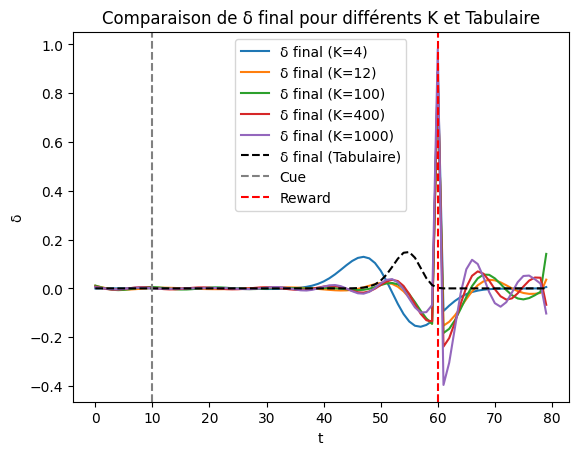

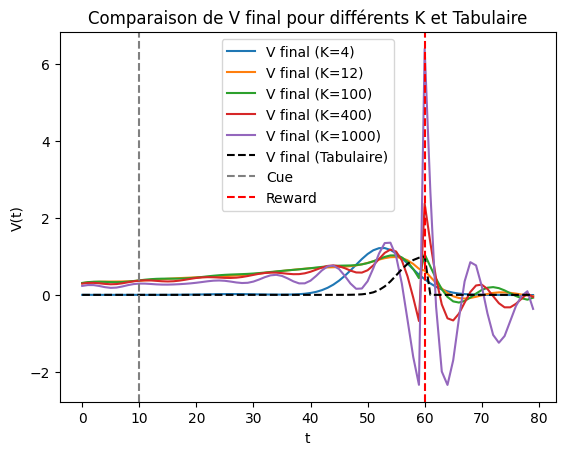

In [112]:
Ks = [4, 12, 100, 400, 1000]
results = {}

# Train models for each K and store the results
for K in Ks:
    Phi = gaussian_time_bases(T, K, sigma=5.0)
    model = TDLinearFeatures(Phi, reward_time=60, alpha=0.08, gamma=0.98)
    train_d, train_V = train(model, n_train=120)
    results[K] = (train_d, train_V)

# Add the reference tabular model
model_tabular = TDTabularSerialCompound(T=80, cue_time=10, reward_time=60, alpha=0.05, gamma=0.98)
train_d_tabular, train_V_tabular = train(model_tabular, n_train=120)

# Plot the results for each K and the reference tabular model
plt.figure()
for K in Ks:
    train_d, _ = results[K]
    plt.plot(t, train_d[-1], label=f'δ final (K={K})')
plt.plot(t, train_d_tabular[-1], label='δ final (Tabulaire)', linestyle='--', color='black')
plt.axvline(10, linestyle='--', color='gray', label='Cue')
plt.axvline(60, linestyle='--', color='red', label='Reward')
plt.xlabel('t')
plt.ylabel('δ')
plt.legend()
plt.title('Comparaison de δ final pour différents K et Tabulaire')
plt.show()

plt.figure()
for K in Ks:
    _, train_V = results[K]
    plt.plot(t, train_V[-1], label=f'V final (K={K})')
plt.plot(t, train_V_tabular[-1], label='V final (Tabulaire)', linestyle='--', color='black')
plt.axvline(10, linestyle='--', color='gray', label='Cue')
plt.axvline(60, linestyle='--', color='red', label='Reward')
plt.xlabel('t')
plt.ylabel('V(t)')
plt.legend()
plt.title('Comparaison de V final pour différents K et Tabulaire')
plt.show()


<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
<strong>Influence du nombre de bases temporelles K — signal d’erreur δ.</strong><br>
Ce graphique compare le signal d’erreur de prédiction final pour différents nombres de bases temporelles K.
Lorsque K est faible (par exemple K = 6), le signal δ présente des oscillations importantes et un pic excessif au moment de la récompense.
Cela indique une capacité d’approximation insuffisante : avec trop peu de bases, le modèle ne peut pas représenter correctement un événement temporel ponctuel,
ce qui conduit à des phénomènes d’overshoot et d’undershoot.
</div>


<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
Lorsque K augmente (K = 12 ou K = 24), les oscillations du signal δ diminuent nettement.
Le signal reste étalé dans le temps mais devient plus stable, ce qui reflète un meilleur compromis entre généralisation temporelle
et précision locale de l’erreur de prédiction.
Pour des valeurs élevées de K (K = 48 ou K = 96), le signal δ devient plus localisé autour du temps de récompense,
et le comportement du modèle se rapproche progressivement de celui d’un modèle tabulaire.
</div>


Le modèle reste partiellement surpris non pas parce qu’il n’a pas appris, mais parce que sa représentation impose une approximation lisse d’un événement temporel discret. L’erreur de prédiction résiduelle reflète une limite de capacité et un compromis entre généralisation temporelle et précision locale.

### Variation de $\sigma$

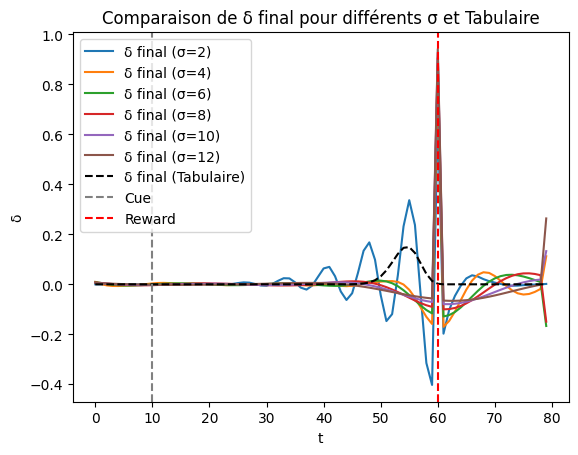

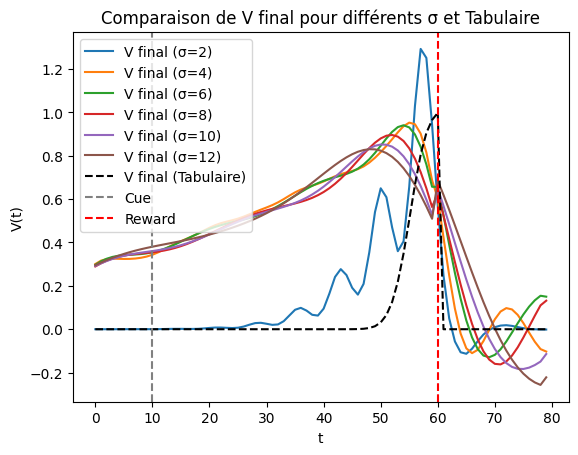

In [113]:
K =12 
sigmas = [2,4,6,8,10,12]
results_sigma = {}

# Train models for each sigma and store the results
for sigma in sigmas:
    Phi_sigma = gaussian_time_bases(T, K, sigma=sigma)
    model_sigma = TDLinearFeatures(Phi_sigma, reward_time=60, alpha=0.08, gamma=0.98)
    train_d_sigma, train_V_sigma = train(model_sigma, n_train=120)
    results_sigma[sigma] = (train_d_sigma, train_V_sigma)

# Add the reference tabular model to results_sigma
results_sigma['Tabular'] = (train_d_tabular, train_V_tabular)

# Plot the results for each sigma, including the tabular model for comparison
plt.figure()
for sigma in sigmas:
    train_d_sigma, _ = results_sigma[sigma]
    plt.plot(t, train_d_sigma[-1], label=f'δ final (σ={sigma})')
train_d_tabular, _ = results_sigma['Tabular']
plt.plot(t, train_d_tabular[-1], label='δ final (Tabulaire)', linestyle='--', color='black')
plt.axvline(10, linestyle='--', color='gray', label='Cue')
plt.axvline(60, linestyle='--', color='red', label='Reward')
plt.xlabel('t')
plt.ylabel('δ')
plt.legend()
plt.title('Comparaison de δ final pour différents σ et Tabulaire')
plt.show()

plt.figure()
for sigma in sigmas:
    _, train_V_sigma = results_sigma[sigma]
    plt.plot(t, train_V_sigma[-1], label=f'V final (σ={sigma})')
_, train_V_tabular = results_sigma['Tabular']
plt.plot(t, train_V_tabular[-1], label='V final (Tabulaire)', linestyle='--', color='black')
plt.axvline(10, linestyle='--', color='gray', label='Cue')
plt.axvline(60, linestyle='--', color='red', label='Reward')
plt.xlabel('t')
plt.ylabel('V(t)')
plt.legend()
plt.title('Comparaison de V final pour différents σ et Tabulaire')
plt.show()


<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
Ces graphiques montrent que la largeur des bases temporelles σ contrôle directement le compromis entre précision temporelle et généralisation. 
Pour des valeurs faibles de σ, le modèle se comporte de manière quasi tabulaire : le signal d’erreur δ et la fonction de valeur V(t) présentent de fortes oscillations et des pics localisés autour de la récompense, traduisant une représentation trop sensible au timing exact. 
À l’inverse, lorsque σ augmente, les oscillations diminuent et les courbes deviennent plus lisses ; la surprise au moment précis de la récompense est atténuée mais s’étale sur une fenêtre temporelle plus large. 
Les valeurs intermédiaires de σ permettent d’obtenir un compromis pertinent, avec une montée régulière de V(t) entre le cue et la récompense et un signal δ plus stable, reflétant une généralisation temporelle contrôlée sans perte excessive de précision locale.
</div>


<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
Ces graphiques montrent que la largeur des bases temporelles σ influence principalement la forme temporelle du signal d’erreur de prédiction δ, mais très peu son amplitude maximale au moment du reward. 
En effet, le pic de δ à la récompense reste d’ordre comparable pour différentes valeurs de σ, car il est essentiellement déterminé par la magnitude de la récompense et par la valeur prédite immédiatement avant celle-ci, et non par le lissage de la représentation temporelle. 
En revanche, σ contrôle la manière dont l’erreur est distribuée autour de ce pic : pour des σ faibles, δ est fortement localisé et s’accompagne d’oscillations marquées, tandis que pour des σ élevés, le signal devient plus lisse et s’étale sur une fenêtre temporelle plus large. 
Ainsi, σ n’affecte pas directement l’intensité de la surprise au moment du reward, mais détermine sa dispersion temporelle et la stabilité du signal d’erreur.
</div>


## 2) Amélioration #2 — Approximation non-linéaire (MLP en NumPy)

On remplace \(V(t)=w^\top\phi(t)\) par \(V(t)=f_\theta(\phi(t))\) avec un petit MLP :  
- \(h=\tanh(W1\phi+b1)\)  
- \(V=W2h+b2\)

Update TD :
$\theta \leftarrow \theta + \alpha\,\delta_t\,\nabla_\theta V(t)$

Ici on code les gradients à la main : tu vois exactement où sont les poids.


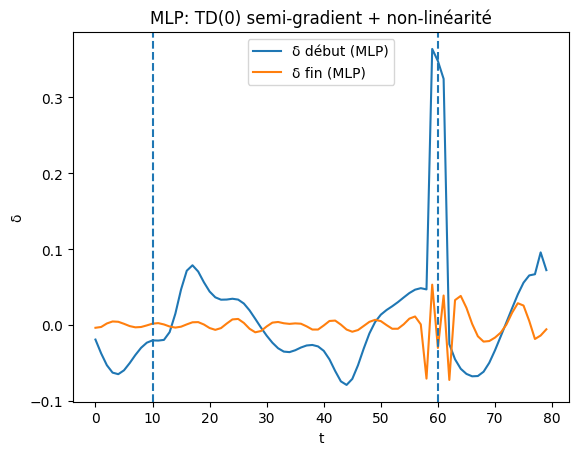

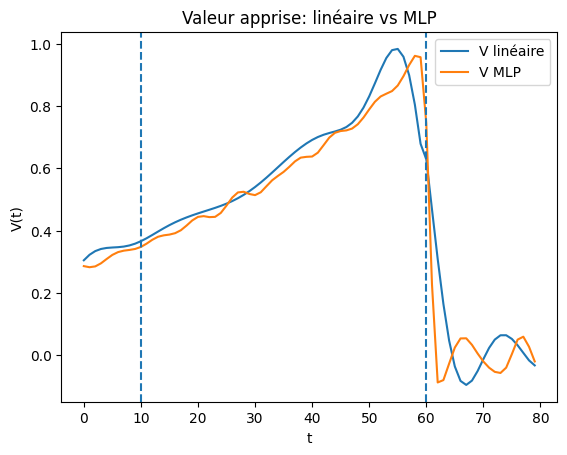

In [114]:
# --- MLP Value Function + TD(0) (semi-gradient) en NumPy ---
# Objectif : approximer V(t) = f_theta(phi(t)) avec un MLP 1-couche cachée,
# et entraîner les paramètres avec TD(0) en utilisant le SEMI-GRADIENT :
# on traite la cible (r + gamma*V(t+1)) comme constante, et on rétro-propage
# uniquement à travers V(t). C’est la version standard en RL avec approximateurs.

class TinyMLPValue:
    """
    MLP 1-couche cachée + TD(0) (semi-gradient) + gradients à la main.
    
    - Représentation temporelle : phi(t) (bases gaussiennes ou autres)
    - Approximation non-linéaire : V(t) = W2 · tanh(W1 phi(t) + b1) + b2
    - Apprentissage : semi-gradient TD(0)
    
    Options de stabilisation (fortement recommandées en TD + non-linéarité) :
    - delta_clip : borne δ pour éviter des updates explosifs près du reward
    - l2 : petite décroissance des poids (régularisation L2 / weight decay)
    """
    def __init__(self, Phi, reward_time=60, alpha=0.01, gamma=0.98, hidden=20,
                 delta_clip=None, l2=0.0):
        self.Phi = np.asarray(Phi)
        self.T, self.K = self.Phi.shape
        self.reward_time = int(reward_time)
        self.alpha = float(alpha)
        self.gamma = float(gamma)
        self.hidden = int(hidden)

        # Stabilisation
        self.delta_clip = delta_clip  # ex: 1.0 (ou None pour désactiver)
        self.l2 = float(l2)           # ex: 1e-4

        # --- Poids du MLP ---
        # Initialisation petite pour éviter saturation tanh dès le début.
        self.W1 = 0.1 * np.random.randn(self.hidden, self.K)
        self.b1 = np.zeros(self.hidden)
        self.W2 = 0.1 * np.random.randn(self.hidden)
        self.b2 = 0.0

    def forward(self, phi):
        """
        Passe avant : retourne V et un cache (phi, h) utile pour le backward.
        On stocke h = tanh(z1) pour éviter de recalculer tanh(z1) dans le gradient.
        """
        z1 = self.W1 @ phi + self.b1          # (hidden,)
        h = np.tanh(z1)                        # (hidden,)
        V = float(self.W2 @ h + self.b2)       # scalaire
        cache = (phi, h)                       # z1 inutile si on a h
        return V, cache

    def V(self, t):
        """Valeur prédite au temps t (0 si hors bornes)."""
        if t < 0 or t >= self.T:
            return 0.0
        Vt, _ = self.forward(self.Phi[t])
        return Vt

    def grad_V(self, cache):
        """
        Gradients de V(t) par rapport aux paramètres.
        V = W2·h + b2, h = tanh(W1 phi + b1)
        
        On utilise (1 - h^2) au lieu de (1 - tanh(z1)^2) :
        - plus propre (on a déjà h)
        - évite un recalcul
        """
        phi, h = cache

        # ∂V/∂W2 = h ; ∂V/∂b2 = 1
        dW2 = h.copy()
        db2 = 1.0

        # ∂V/∂h = W2
        dh = self.W2.copy()

        # h = tanh(z) => ∂h/∂z = 1 - h^2
        dz = dh * (1.0 - h**2)                # (hidden,)

        # z = W1 phi + b1
        dW1 = np.outer(dz, phi)               # (hidden, K)
        db1 = dz                              # (hidden,)

        return dW1, db1, dW2, db2

    def run_trial(self, reward_delivered=True, reward_value=1.0, return_pre_update=True):
        """
        Simule un essai sur t=0..T-1.

        TD(0) semi-gradient :
            δ_t = r_t + γ V(t+1) - V(t)
            θ ← θ + α δ_t ∇_θ V(t)
        La cible (r + γ V(t+1)) est traitée comme constante (pas de gradient via V(t+1)).

        return_pre_update:
            - True  -> V_trace[t] contient V(t) AVANT update (plus interprétable)
            - False -> V_trace[t] contient V(t) APRÈS update
        """
        r = np.zeros(self.T)
        if reward_delivered and 0 <= self.reward_time < self.T:
            r[self.reward_time] = reward_value

        deltas = np.zeros(self.T)
        V_trace = np.zeros(self.T)

        for t in range(self.T):
            # Valeur et cache au temps t
            Vt, cache = self.forward(self.Phi[t])

            # Bootstrapping : V(t+1) (traité comme constante pour le gradient)
            Vtp1 = self.V(t + 1)

            # Erreur TD
            delta = r[t] + self.gamma * Vtp1 - Vt

            # Option : clipping de δ pour éviter updates instables autour du reward
            if self.delta_clip is not None:
                delta = float(np.clip(delta, -self.delta_clip, self.delta_clip))

            # Sauvegarde V(t) (avant ou après update, au choix)
            if return_pre_update:
                V_trace[t] = Vt

            # Gradients de V(t) et update semi-gradient
            dW1, db1, dW2, db2 = self.grad_V(cache)

            # Option : L2 / weight decay (stabilisation simple et efficace)
            if self.l2 > 0.0:
                self.W1 *= (1.0 - self.alpha * self.l2)
                self.W2 *= (1.0 - self.alpha * self.l2)
                # (On laisse souvent b1, b2 sans decay)

            # Update TD(0)
            self.W1 += self.alpha * delta * dW1
            self.b1 += self.alpha * delta * db1
            self.W2 += self.alpha * delta * dW2
            self.b2 += self.alpha * delta * db2

            # Si on veut V après update, on le recalcule proprement (optionnel)
            if not return_pre_update:
                V_trace[t] = self.V(t)

            deltas[t] = delta

        return deltas, V_trace, r


# --- Entraînement + figures (identique en sortie, mais plus propre/stable) ---
set_seed(1)

# Conseils pratiques :
# - delta_clip=1.0 évite des explosions (surtout avec tanh + TD).
# - l2=1e-4 stabilise sans changer la logique.
model2 = TinyMLPValue(
    Phi, reward_time=60,
    alpha=0.01, gamma=0.98, hidden=20,
    delta_clip=1.0, l2=1e-4
)

train_d2, train_V2 = train(model2, n_train=400)

# Courbe δ : moyenne mobile pour lisibilité
plt.figure()
plt.plot(t, moving_average(train_d2[0], 3), label='δ début (MLP)')
plt.plot(t, moving_average(train_d2[-1], 3), label='δ fin (MLP)')
plt.axvline(10, linestyle='--'); plt.axvline(60, linestyle='--')
plt.xlabel('t'); plt.ylabel('δ'); plt.legend()
plt.title('MLP: TD(0) semi-gradient + non-linéarité')
plt.show()

plt.figure()
plt.plot(t, train_V1[-1], label='V linéaire')
plt.plot(t, train_V2[-1], label='V MLP')
plt.axvline(10, linestyle='--'); plt.axvline(60, linestyle='--')
plt.xlabel('t'); plt.ylabel('V(t)'); plt.legend()
plt.title('Valeur apprise: linéaire vs MLP')
plt.show()


<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
Ces graphiques montrent que l’introduction d’un MLP améliore la flexibilité de l’approximation de la fonction de valeur sans éliminer complètement la surprise résiduelle.
Après apprentissage, le signal d’erreur δ est fortement réduit sur la majorité de la trajectoire, indiquant une bonne prédiction de la valeur attendue, mais un pic persiste autour de la récompense en raison du TD(0) semi-gradient et du bootstrapping.
La fonction de valeur apprise par le MLP est plus lisse que celle du modèle linéaire, tout en conservant une amplitude comparable au moment du reward.
La non-linéarité améliore donc la forme et la stabilité de V(t), sans permettre une annulation exacte de l’erreur de prédiction au moment de la récompense.
</div>


### Biais de représnetation effet de K et de $\sigma$

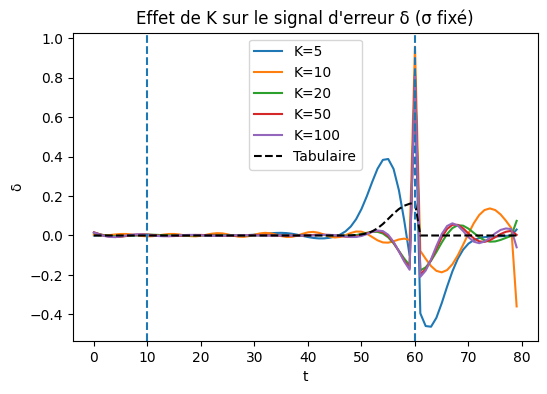

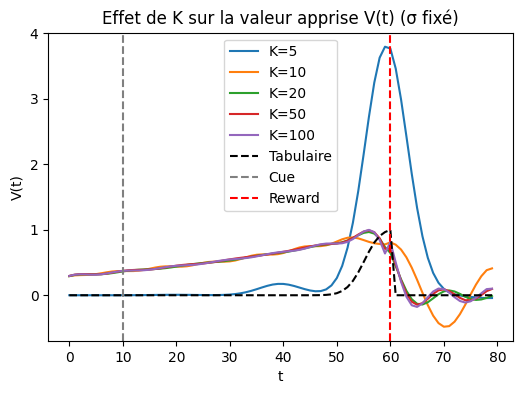

In [115]:
Ks = [5,10,20,50,100]
sigma_fixed = 4

plt.figure(figsize=(6,4))

for K in Ks:
    Phi = gaussian_time_bases(T, K, sigma=sigma_fixed)
    model = TDLinearFeatures(Phi, reward_time=60, alpha=0.05, gamma=0.98)
    D, V = train(model, n_train=300)

    delta_mean = D.mean(axis=0)
    plt.plot(t, delta_mean, label=f"K={K}")

# Add the tabular model for comparison
delta_mean_tabular = train_d_tabular.mean(axis=0)
plt.plot(t, delta_mean_tabular, label="Tabulaire", linestyle="--", color="black")

plt.axvline(10, linestyle="--")
plt.axvline(60, linestyle="--")
plt.xlabel("t")
plt.ylabel("δ")
plt.title("Effet de K sur le signal d'erreur δ (σ fixé)")
plt.legend()
plt.show()
plt.figure(figsize=(6, 4))

for K in Ks:
    Phi = gaussian_time_bases(T, K, sigma=sigma_fixed)
    model = TDLinearFeatures(Phi, reward_time=60, alpha=0.05, gamma=0.98)
    D, V = train(model, n_train=300)

    V_final = V[-1]
    plt.plot(t, V_final, label=f"K={K}")

# Add the tabular model for comparison
V_final_tabular = train_V_tabular[-1]
plt.plot(t, V_final_tabular, label="Tabulaire", linestyle="--", color="black")

plt.axvline(10, linestyle="--", color="gray", label="Cue")
plt.axvline(60, linestyle="--", color="red", label="Reward")
plt.xlabel("t")
plt.ylabel("V(t)")
plt.title("Effet de K sur la valeur apprise V(t) (σ fixé)")
plt.legend()
plt.show()


<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
Ce graphique montre que le nombre de bases temporelles K contrôle principalement la localisation temporelle du signal d’erreur de prédiction δ, sans modifier fortement son amplitude maximale au moment de la récompense.
Pour des valeurs faibles de K, le signal δ est étalé dans le temps et s’accompagne d’oscillations marquées avant et après la récompense, traduisant une capacité d’approximation insuffisante.
À mesure que K augmente, le pic de δ devient plus étroit et plus localisé autour du reward, et les oscillations périphériques diminuent.
Le modèle se rapproche alors d’un comportement tabulaire, au prix d’une réduction de la généralisation temporelle.
</div>


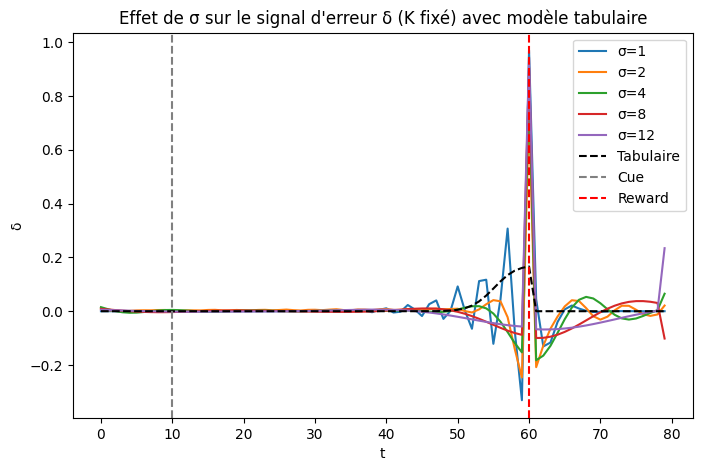

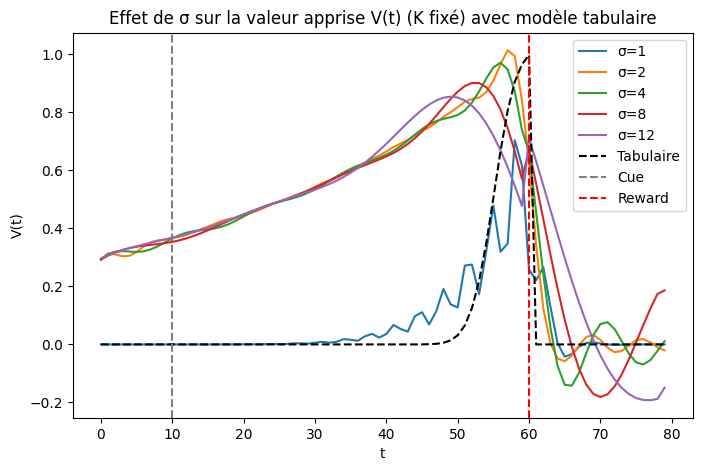

In [116]:
# Étude 1B — Effet de la largeur des bases sigma (K fixé) avec comparaison tabulaire

K_fixed = 24
sigmas = [1, 2, 4, 8, 12]

# Tracer les courbes pour δ (delta)
plt.figure(figsize=(8, 5))
for sigma in sigmas:
    Phi = gaussian_time_bases(T, K_fixed, sigma=sigma)
    model = TDLinearFeatures(Phi, reward_time=60, alpha=0.05, gamma=0.98)
    D, V = train(model, n_train=300)

    delta_mean = D.mean(axis=0)
    plt.plot(t, delta_mean, label=f"σ={sigma}")

# Ajouter la courbe pour le modèle tabulaire
delta_mean_tabular = train_d_tabular.mean(axis=0)
plt.plot(t, delta_mean_tabular, label="Tabulaire", linestyle="--", color="black")

plt.axvline(10, linestyle="--", color="gray", label="Cue")
plt.axvline(60, linestyle="--", color="red", label="Reward")
plt.xlabel("t")
plt.ylabel("δ")
plt.title("Effet de σ sur le signal d'erreur δ (K fixé) avec modèle tabulaire")
plt.legend()
plt.show()

# Tracer les courbes pour \( V(t) \)
plt.figure(figsize=(8, 5))
for sigma in sigmas:
    Phi = gaussian_time_bases(T, K_fixed, sigma=sigma)
    model = TDLinearFeatures(Phi, reward_time=60, alpha=0.05, gamma=0.98)
    _, V = train(model, n_train=300)

    V_final = V[-1]
    plt.plot(t, V_final, label=f"σ={sigma}")

# Ajouter la courbe pour le modèle tabulaire
V_final_tabular = train_V_tabular[-1]
plt.plot(t, V_final_tabular, label="Tabulaire", linestyle="--", color="black")

plt.axvline(10, linestyle="--", color="gray", label="Cue")
plt.axvline(60, linestyle="--", color="red", label="Reward")
plt.xlabel("t")
plt.ylabel("V(t)")
plt.title("Effet de σ sur la valeur apprise V(t) (K fixé) avec modèle tabulaire")
plt.legend()
plt.show()


<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
Ces graphiques montrent que la largeur des bases temporelles σ contrôle le lissage temporel du modèle (K fixé), en comparaison avec un modèle tabulaire.
Lorsque σ est faible, le modèle se rapproche d’un encodage tabulaire : le signal d’erreur δ est très localisé autour de la récompense et s’accompagne d’oscillations marquées avant et après celle-ci, tandis que la valeur apprise V(t) monte de manière plus irrégulière et présente une transition très abrupte au moment du reward.
À mesure que σ augmente, δ devient plus lisse et plus étalé dans le temps : la surprise est moins concentrée au moment exact de la récompense et se répartit sur une fenêtre temporelle plus large.
De même, V(t) devient plus régulière et se rapproche d’une rampe lissée, mais au prix d’une précision locale moindre autour de la récompense, avec des oscillations post-reward plus longues.
Le modèle tabulaire correspond au cas limite : localisation maximale de la prédiction et de l’erreur, sans généralisation temporelle.
</div>


### Analyse des résultats sous bruit et variabilité temporelle

### Analyse des résultats sous bruit et variabilité temporelle

Dans cette section, nous analysons les performances du modèle lorsqu'il est soumis à des conditions de bruit et de variabilité temporelle. Plus précisément :

1. **Bruit sur le timing de la récompense :**  
    Le moment de la récompense (`reward_time`) est tiré aléatoirement autour d'une moyenne (`reward_time_mean`) avec une incertitude (jitter). Cela simule une situation où la récompense n'est pas toujours délivrée au même moment.

2. **Récompense probabiliste :**  
    La récompense est délivrée avec une probabilité donnée (`p_reward`). Cela introduit des omissions aléatoires, reflétant des environnements où la récompense n'est pas garantie.

3. **Wrapper pour bruit :**  
    Un wrapper (`NoisyTrialWrapper`) est utilisé pour ajouter ces sources de bruit sans modifier le modèle interne. Ce wrapper gère le tirage aléatoire du `reward_time` et la probabilité de livraison de la récompense.

4. **Entraînement sous bruit :**  
    Le modèle est entraîné sur plusieurs essais bruités. Les résultats incluent les erreurs de prédiction (`δ`), les valeurs apprises (`V(t)`), les moments de récompense tirés, et les indicateurs de livraison de la récompense.

5. **Visualisation des résultats :**  
    - **Erreur de prédiction en temps absolu :**  
      Le signal d'erreur moyen (`δ`) est tracé en fonction du temps absolu, avec une indication de la distribution du `reward_time` (moyenne et étendue du jitter). Cela montre comment le bruit temporel affecte la propagation de l'erreur.
    - **Erreur de prédiction réalignée :**  
      Les courbes de `δ` sont réalignées sur le moment de la récompense pour observer le profil moyen de l'erreur autour de cet événement, indépendamment du jitter.
    - **Valeur moyenne :**  
      La valeur moyenne apprise (`V(t)`) est tracée avec son écart-type, montrant comment le modèle s'adapte aux conditions bruitées.

6. **Statistiques :**  
    Les taux de livraison de la récompense et les statistiques du `reward_time` (moyenne et écart-type) sont calculés pour résumer les conditions expérimentales.

Cette analyse permet d'évaluer la robustesse du modèle face à des environnements incertains et de comprendre comment le bruit temporel et les omissions affectent les prédictions et l'apprentissage.


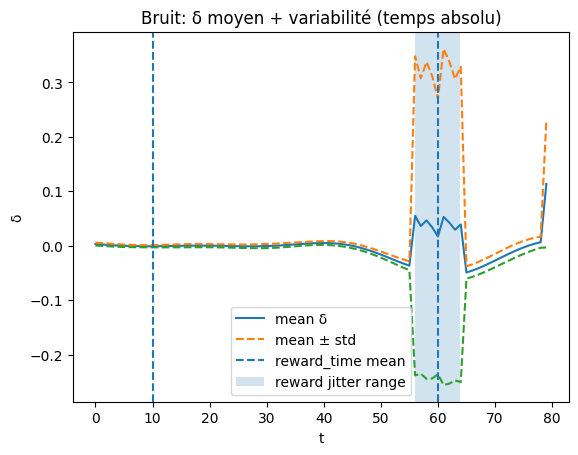

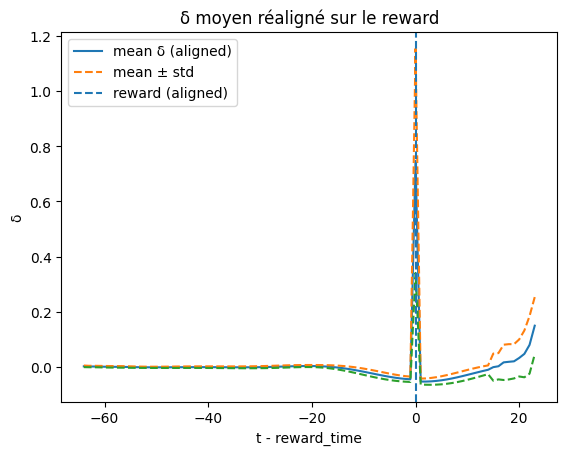

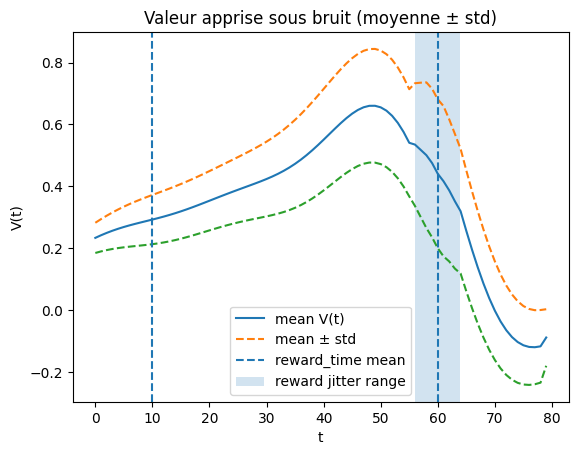

Taux reward livrée = 0.7916666666666666
reward_time moyen = 59.95166666666667 +/- 2.595379976462449


In [117]:
# --- Bruit sur reward_time + reward probabiliste (wrapper propre + plots corrects) ---
# Objectifs :
# 1) Simuler un timing de reward incertain : reward_time ~ Uniform[mu-jitter, mu+jitter]
# 2) Simuler des omissions : reward_delivered ~ Bernoulli(p_reward)
# 3) Garder le modèle inchangé (on wrappe), MAIS sans effets de bord dangereux
# 4) Produire des plots interprétables :
#    - en temps absolu (t) : on montre l'étalement dû au jitter
#    - réaligné sur le reward : on observe le profil de δ autour du reward
#    - V(t) : éviter de tracer "le dernier essai" (souvent non représentatif)

import numpy as np
import matplotlib.pyplot as plt


class NoisyTrialWrapper:
    """
    Randomise reward_time + reward delivery, sans modifier le code du modèle interne.
    
    - reward_time est tiré autour d'une moyenne (reward_time_mean) avec jitter (entier)
    - reward est livré avec probabilité p_reward
    """
    def __init__(self, base_model, reward_time_mean=60, jitter_reward=4, p_reward=0.8):
        self.m = base_model
        self.T = int(base_model.T)

        self.reward_time_mean = int(reward_time_mean)
        self.jitter_reward = int(jitter_reward)
        self.p_reward = float(p_reward)

    def sample_reward_time(self):
        """Tire un reward_time jittered et le clip dans [0, T-1]."""
        if self.jitter_reward <= 0:
            return self.reward_time_mean
        rt = self.reward_time_mean + np.random.randint(-self.jitter_reward, self.jitter_reward + 1)
        return int(np.clip(rt, 0, self.T - 1))

    def sample_delivery(self):
        """Tire si la récompense est délivrée."""
        return bool(np.random.rand() < self.p_reward)

    def run_trial(self, reward_value=1.0):
        """
        Lance un essai bruité.
        Retourne: deltas, V_trace, r, rew_t, delivered
        """
        rew_t = self.sample_reward_time()
        delivered = self.sample_delivery()

        # On modifie temporairement reward_time du modèle, puis on restore quoi qu'il arrive.
        old = getattr(self.m, "reward_time", None)
        try:
            self.m.reward_time = rew_t
            deltas, V_trace, r = self.m.run_trial(reward_delivered=delivered, reward_value=reward_value)
        finally:
            self.m.reward_time = old

        return deltas, V_trace, r, rew_t, delivered


def train_noisy(wrapper, n=600, reward_value=1.0):
    """
    Entraîne sur n essais bruités.
    Retourne :
      D: (n, T) deltas
      V: (n, T) valeurs tracées
      rew: (n,) reward_time tirés
      deliv: (n,) bools de reward livré
    """
    D, V, rew, deliv = [], [], [], []
    for _ in range(n):
        d, vt, _, rt, dv = wrapper.run_trial(reward_value=reward_value)
        D.append(d); V.append(vt); rew.append(rt); deliv.append(dv)
    return np.array(D), np.array(V), np.array(rew), np.array(deliv)


def align_by_reward(D, rew_times, T, center=0, fill_value=np.nan):
    """
    Réaligne chaque courbe D[i, :] pour que reward_time devienne 'center' (en index relatif).
    On renvoie un tableau (n, 2*max_shift+1) en indices relatifs centrés.
    
    Exemple : center=0 => l'index 0 correspond au reward (t - rew_time = 0).
    """
    n = D.shape[0]
    # On choisit une fenêtre relative qui tient pour tout le monde :
    left = -np.max(rew_times)                 # min (t - rew_t) possible
    right = (T - 1) - np.min(rew_times)       # max (t - rew_t) possible
    rel_t = np.arange(left, right + 1)

    A = np.full((n, rel_t.size), fill_value, dtype=float)

    for i in range(n):
        rt = rew_times[i]
        # Pour chaque t absolu, t_rel = t - rt
        t_abs = np.arange(T)
        t_rel = t_abs - rt
        # mappe t_rel vers indices dans rel_t
        idx = t_rel - left
        A[i, idx] = D[i]
    return rel_t, A


# -------------------- Démo complète --------------------
# Hypothèses: tu as déjà set_seed, Phi, TDLinearFeatures, t, T dans ton notebook.
# Sinon, définis T, t = np.arange(T) au-dessus.

set_seed(2)
model3 = TDLinearFeatures(Phi, reward_time=60, alpha=0.06, gamma=0.98)
wrap = NoisyTrialWrapper(model3, reward_time_mean=60, jitter_reward=4, p_reward=0.8)

D3, V3, rew3, deliv3 = train_noisy(wrap, n=600)

# -------------------- Plot 1 : δ en temps absolu (t) --------------------
# Ici, l'étalement est NORMAL puisque le reward bouge d'un essai à l'autre.
m = D3.mean(axis=0)
s = D3.std(axis=0)

plt.figure()
plt.plot(t, m, label="mean δ")
plt.plot(t, m + s, linestyle="--", label="mean ± std")
plt.plot(t, m - s, linestyle="--")

# Au lieu d'une ligne "Reward=60" fixe, on indique la distribution du reward_time.
rt_mean = rew3.mean()
rt_std = rew3.std()
plt.axvline(rt_mean, linestyle="--", label="reward_time mean")
plt.axvspan(rt_mean - wrap.jitter_reward, rt_mean + wrap.jitter_reward, alpha=0.2, label="reward jitter range")

plt.axvline(10, linestyle="--")  # cue fixe dans ton setup
plt.xlabel("t")
plt.ylabel("δ")
plt.legend()
plt.title("Bruit: δ moyen + variabilité (temps absolu)")
plt.show()

# -------------------- Plot 2 : δ réaligné sur le reward --------------------
# Ici, on voit le profil moyen de δ autour du reward, indépendamment du jitter.
rel_t, A = align_by_reward(D3, rew3, T=T)
m_rel = np.nanmean(A, axis=0)
s_rel = np.nanstd(A, axis=0)

plt.figure()
plt.plot(rel_t, m_rel, label="mean δ (aligned)")
plt.plot(rel_t, m_rel + s_rel, linestyle="--", label="mean ± std")
plt.plot(rel_t, m_rel - s_rel, linestyle="--")
plt.axvline(0, linestyle="--", label="reward (aligned)")
plt.xlabel("t - reward_time")
plt.ylabel("δ")
plt.legend()
plt.title("δ moyen réaligné sur le reward")
plt.show()

# -------------------- Plot 3 : V(t) moyen plutôt que le dernier essai --------------------
V_mean = V3.mean(axis=0)
V_std = V3.std(axis=0)

plt.figure()
plt.plot(t, V_mean, label="mean V(t)")
plt.plot(t, V_mean + V_std, linestyle="--", label="mean ± std")
plt.plot(t, V_mean - V_std, linestyle="--")

plt.axvline(rt_mean, linestyle="--", label="reward_time mean")
plt.axvspan(rt_mean - wrap.jitter_reward, rt_mean + wrap.jitter_reward, alpha=0.2, label="reward jitter range")
plt.axvline(10, linestyle="--")  # cue
plt.xlabel("t")
plt.ylabel("V(t)")
plt.legend()
plt.title("Valeur apprise sous bruit (moyenne ± std)")
plt.show()

print("Taux reward livrée =", float(deliv3.mean()))
print("reward_time moyen =", float(rt_mean), "+/-", float(rt_std))


<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
<strong>δ moyen en temps absolu.</strong>
La courbe bleue représente le signal d’erreur de prédiction moyen, tandis que les courbes orange et verte indiquent respectivement la moyenne plus et moins un écart-type.
L’augmentation marquée de la variabilité autour du reward reflète l’incertitude sur le timing de la récompense et sur sa délivrance.
En dehors de cette fenêtre, δ reste proche de zéro, ce qui indique que le modèle prédit correctement la valeur attendue en moyenne.
</div>

<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
<strong>δ moyen réaligné sur le reward.</strong>
Après réalignement temporel, le signal δ présente un pic net centré sur le moment effectif de la récompense, tandis qu’il est quasi nul ailleurs.
Cela montre que l’erreur observée en temps absolu est principalement due au jitter du reward et non à une mauvaise estimation de la valeur.
Le modèle apprend donc une anticipation correcte conditionnée à l’occurrence de l’événement.
</div>

<div style="border-left: 5px solid #2ecc71; padding: 10px; background-color: #f0fff4; color: black;">
<strong>Valeur apprise sous bruit.</strong>
La courbe bleue montre la valeur moyenne apprise, et les courbes orange et verte encadrent sa variabilité.
La montée progressive de V(t) traduit l’anticipation de la récompense, tandis que l’étalement et l’incertitude autour du maximum reflètent la distribution temporelle et probabiliste du reward.
Après la récompense, la valeur décroît vers zéro, indiquant qu’il n’y a plus de gain attendu.
</div>


### Modèle Actor–Critic

Le modèle Actor–Critic est composé de deux modules complémentaires : un **critique**, qui apprend à prédire la valeur attendue d’une récompense future, et un **acteur**, qui apprend à prendre des décisions à partir de cette prédiction.  
L’état est ici représenté par le temps $t$ via un vecteur de caractéristiques $\phi(t)$, ce qui permet de modéliser explicitement l’anticipation temporelle de la récompense.

---

### Critique (apprentissage de la valeur)

Le critique approxime la fonction de valeur
$$
V(t) = \mathbb{E}\left[\sum_{k \ge 0} \gamma^k r(t+k)\right],
$$
c’est-à-dire l’espérance de la récompense future cumulée à partir du temps $t$.  
Il est entraîné par **TD(0)** à l’aide de l’erreur de prédiction
$$
\delta_t = r(t) + \gamma V(t+1) - V(t),
$$
qui mesure la surprise du modèle et sert à corriger la prédiction de valeur.

---

### Acteur (apprentissage de la politique)

L’acteur apprend une politique stochastique $\pi(a|t)$ qui associe à chaque état une probabilité d’action.  
Dans ce modèle, la politique est paramétrée par une fonction logistique :
$$
\pi(a=1|t) = \sigma(\theta^\top \phi(t)).
$$
Les paramètres $\theta$ sont mis à jour par un gradient de politique, en utilisant l’erreur de prédiction $\delta_t$ fournie par le critique comme signal d’avantage.

---

### Interaction acteur–critique

Le signal $\delta_t$ joue un rôle central :  
- un $\delta_t$ positif renforce les actions qui ont précédé une amélioration de la prédiction,  
- un $\delta_t$ négatif affaiblit celles qui ont conduit à une surestimation.  

Ainsi, le critique apprend à prédire le futur, tandis que l’acteur apprend à agir pour maximiser la valeur prédite.

---

### Interprétation

Dans ce cadre temporel, la politique apprise ne correspond pas à un instant fixe, mais à une anticipation probabiliste de la récompense.  
Sous incertitude sur le timing du reward, l’acteur ajuste progressivement ses décisions pour refléter la distribution temporelle de la récompense, guidé par le signal d’erreur du critique.


In [118]:
import numpy as np
import matplotlib.pyplot as plt


class LinearActor:
    def __init__(self, Phi, alpha=0.01):
        self.Phi = Phi
        self.T, self.K = Phi.shape
        self.alpha = alpha
        self.theta = np.zeros(self.K)

    def policy(self, t):
        z = self.theta @ self.Phi[t]
        return 1.0 / (1.0 + np.exp(-z))

    def sample_action(self, t):
        p = self.policy(t)
        return int(np.random.rand() < p)

    def update(self, t, action, advantage):
        # grad log pi(a|t) = (a - p) * phi(t)
        p = self.policy(t)
        grad_logp = (action - p) * self.Phi[t]
        self.theta += self.alpha * advantage * grad_logp



class TDLinearCritic:
    def __init__(self, Phi, reward_time=60, alpha=0.05, gamma=0.98):
        self.Phi = Phi
        self.T, self.K = Phi.shape
        self.reward_time = reward_time
        self.alpha = alpha
        self.gamma = gamma
        self.w = np.zeros(self.K)

    def V(self, t):
        if t < 0 or t >= self.T:
            return 0.0
        return self.w @ self.Phi[t]

    def update(self, t, delta):
        self.w += self.alpha * delta * self.Phi[t]


def run_actor_critic(actor, critic, n_trials=600, reward_value=1.0, action_cost=0.01):
    """
    Environnement modifié :
    - coût à chaque pas si a=1 : r_cost = -action_cost * a
    - reward à t = reward_time seulement si a=1 : r_reward = reward_value * a
      => si l'acteur "rate" le reward (a=0), il ne reçoit rien.
    """
    all_actions = []
    all_deltas = []
    all_values = []
    all_rewards = []

    for _ in range(n_trials):
        actions = np.zeros(critic.T)
        deltas = np.zeros(critic.T)
        values = np.zeros(critic.T)
        rewards = np.zeros(critic.T)

        for t in range(critic.T):
            a = actor.sample_action(t)
            actions[t] = a

            # Récompense = coût d'action + reward conditionné
            r = -action_cost * a
            if t == critic.reward_time:
                r += reward_value * a   # reward seulement si a=1 au bon moment
            rewards[t] = r

            # Critique TD(0)
            Vt = critic.V(t)
            Vtp1 = critic.V(t + 1)
            delta = r + critic.gamma * Vtp1 - Vt

            # Updates
            critic.update(t, delta)
            actor.update(t, a, delta)

            deltas[t] = delta
            values[t] = Vt

        all_actions.append(actions)
        all_deltas.append(deltas)
        all_values.append(values)
        all_rewards.append(rewards)

    return np.array(all_actions), np.array(all_deltas), np.array(all_values), np.array(all_rewards)


set_seed(0)

critic = TDLinearCritic(Phi, reward_time=60, alpha=0.05, gamma=0.98)
actor = LinearActor(Phi, alpha=0.02)

A, D, V, R = run_actor_critic(actor, critic, n_trials=800, reward_value=1.0, action_cost=0.01)


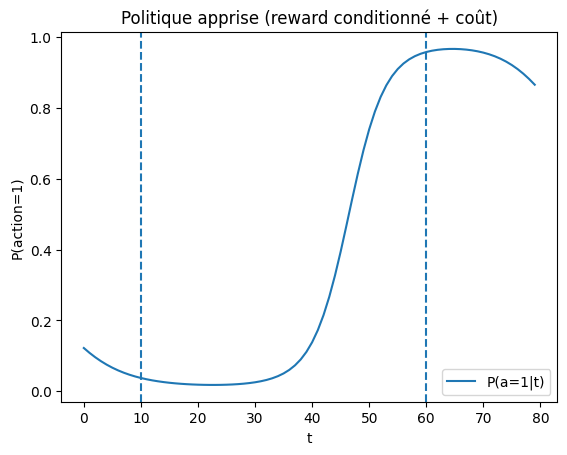

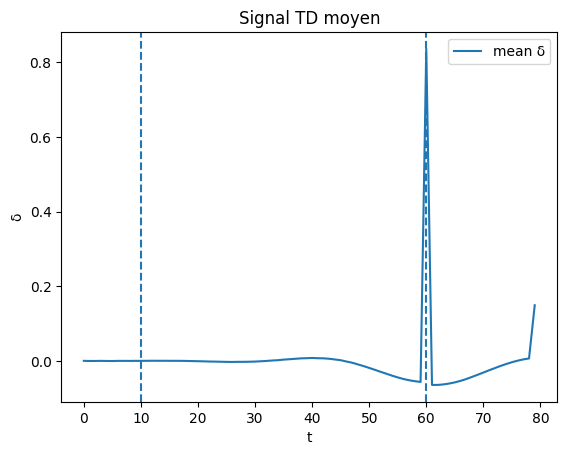

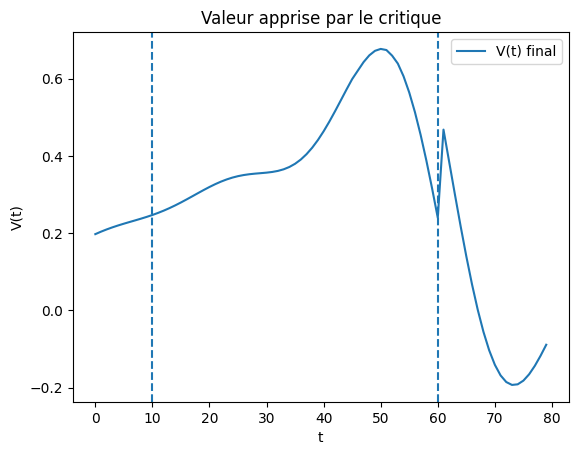

Taux moyen d'action a=1 : 0.468796875
Reward moyen total par épisode : 0.5174624999999999


In [119]:

# Politique apprise
plt.figure()
plt.plot([actor.policy(t) for t in range(T)], label="P(a=1|t)")
plt.axvline(10, linestyle="--")
plt.axvline(60, linestyle="--")
plt.xlabel("t")
plt.ylabel("P(action=1)")
plt.title("Politique apprise (reward conditionné + coût)")
plt.legend()
plt.show()

# δ moyen
plt.figure()
plt.plot(D.mean(axis=0), label="mean δ")
plt.axvline(10, linestyle="--")
plt.axvline(60, linestyle="--")
plt.xlabel("t")
plt.ylabel("δ")
plt.title("Signal TD moyen")
plt.legend()
plt.show()

# Valeur finale
plt.figure()
plt.plot(V[-1], label="V(t) final")
plt.axvline(10, linestyle="--")
plt.axvline(60, linestyle="--")
plt.xlabel("t")
plt.ylabel("V(t)")
plt.title("Valeur apprise par le critique")
plt.legend()
plt.show()

print("Taux moyen d'action a=1 :", float(A.mean()))
print("Reward moyen total par épisode :", float(R.sum(axis=1).mean()))


In [120]:
class MLPActor:
    """
    Acteur MLP 1 couche cachée :
      pi(a=1|t) = sigmoid( W2 · tanh(W1 phi(t) + b1) + b2 )
    Update : policy gradient avec advantage = delta
    """
    def __init__(self, Phi, alpha=0.005, hidden=16, l2=0.0, clip_adv=None):
        self.Phi = Phi
        self.T, self.K = Phi.shape
        self.alpha = float(alpha)
        self.hidden = int(hidden)
        self.l2 = float(l2)
        self.clip_adv = clip_adv  # ex: 1.0

        self.W1 = 0.1 * np.random.randn(self.hidden, self.K)
        self.b1 = np.zeros(self.hidden)
        self.W2 = 0.1 * np.random.randn(self.hidden)
        self.b2 = 0.0

    def _sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def forward(self, t):
        phi = self.Phi[t]
        z1 = self.W1 @ phi + self.b1
        h = np.tanh(z1)
        logit = float(self.W2 @ h + self.b2)
        p = float(self._sigmoid(logit))
        cache = (phi, h, p)
        return p, cache

    def policy(self, t):
        p, _ = self.forward(t)
        return p

    def sample_action(self, t):
        p, _ = self.forward(t)
        return int(np.random.rand() < p)

    def update(self, t, action, advantage):
        # Option : clip de l'avantage (stabilise beaucoup)
        if self.clip_adv is not None:
            advantage = float(np.clip(advantage, -self.clip_adv, self.clip_adv))

        p, cache = self.forward(t)
        phi, h, p = cache

        # grad log pi(a|t) wrt logit : (a - p)
        g = (action - p)

        # gradients
        dW2 = g * h
        db2 = g

        dh = g * self.W2
        dz1 = dh * (1.0 - h**2)

        dW1 = np.outer(dz1, phi)
        db1 = dz1

        # L2 (weight decay) optionnel
        if self.l2 > 0:
            self.W1 *= (1.0 - self.alpha * self.l2)
            self.W2 *= (1.0 - self.alpha * self.l2)

        # update
        lr = self.alpha * advantage
        self.W1 += lr * dW1
        self.b1 += lr * db1
        self.W2 += lr * dW2
        self.b2 += lr * db2


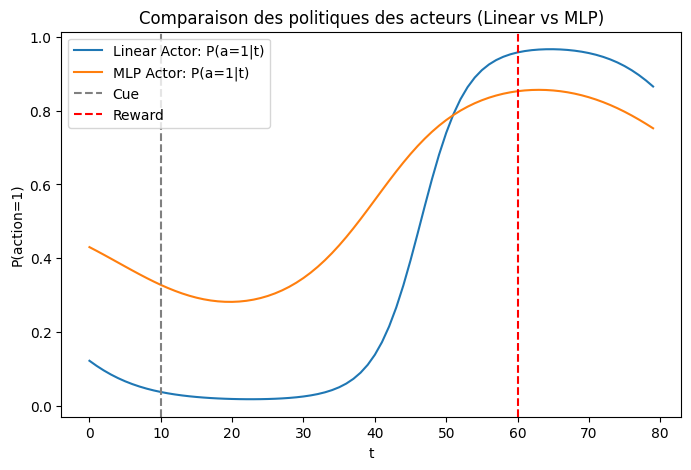

In [121]:
# Comparaison des deux acteurs : LinearActor vs MLPActor
plt.figure(figsize=(8, 5))

# Politique de l'acteur linéaire
plt.plot([actor.policy(t) for t in range(T)], label="Linear Actor: P(a=1|t)")

# Politique de l'acteur MLP
mlp_actor = MLPActor(Phi, alpha=0.005, hidden=16, l2=0.0, clip_adv=1.0)
_, _, _, _ = run_actor_critic(mlp_actor, critic, n_trials=800, reward_value=1.0, action_cost=0.01)
plt.plot([mlp_actor.policy(t) for t in range(T)], label="MLP Actor: P(a=1|t)")

# Ajout des lignes verticales pour le cue et le reward
plt.axvline(10, linestyle="--", color="gray", label="Cue")
plt.axvline(60, linestyle="--", color="red", label="Reward")

# Configuration du graphique
plt.xlabel("t")
plt.ylabel("P(action=1)")
plt.title("Comparaison des politiques des acteurs (Linear vs MLP)")
plt.legend()
plt.show()

Dans notre tâche actuelle, l’état est essentiellement le temps encodé par des bases \(\phi(t)\). Cette représentation est déjà riche : une politique « linéaire sur \(\phi(t)\) » est en pratique déjà non-linéaire en \(t\). Dans ce contexte simple, l’acteur linéaire peut représenter correctement une politique optimale (par exemple une fenêtre d’engagement centrée sur la récompense), et un MLP n’apporte pas forcément de gain. Au contraire, en Actor–Critic le gradient de politique est bruité ; un MLP (plus de paramètres) tend souvent à apprendre une politique plus lisse et plus conservative, ce qui peut donner l’impression qu’il est “moins bon” alors qu’il est surtout surdimensionné pour la tâche.
Le MLP devient réellement avantageux dès que la politique optimale est plus complexe : par exemple si l’agent doit apprendre deux fenêtres d’action distinctes (deux cues menant à deux rewards), ou si la bonne décision dépend d’un contexte. Dans ces cas-là, la politique devient non monotone (deux bosses), et l’acteur non-linéaire a plus de capacité pour représenter et apprendre cette structure.


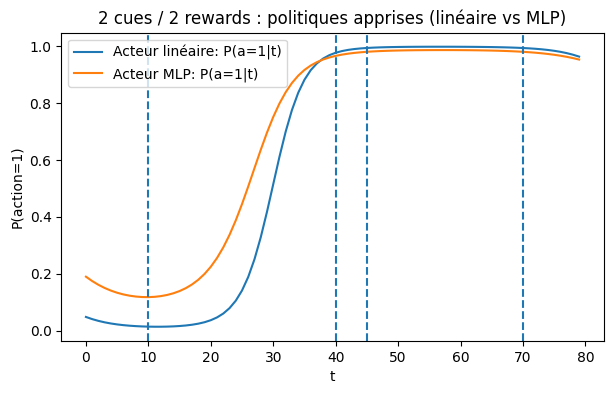

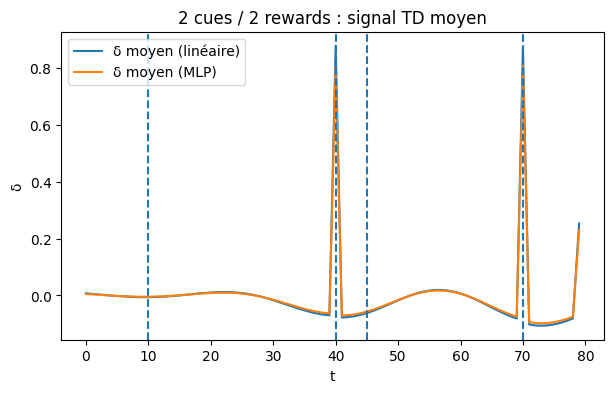

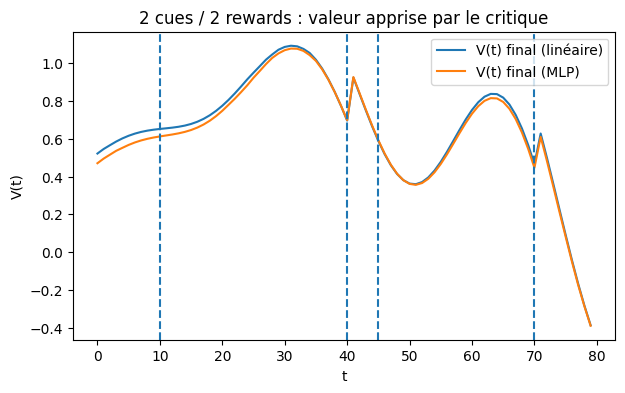

In [122]:
import numpy as np
import matplotlib.pyplot as plt

class MLPActor:
    def __init__(self, Phi, alpha=0.005, hidden=16, l2=1e-4, clip_adv=1.0):
        self.Phi = Phi
        self.T, self.K = Phi.shape
        self.alpha = float(alpha)
        self.hidden = int(hidden)
        self.l2 = float(l2)
        self.clip_adv = clip_adv

        self.W1 = 0.1 * np.random.randn(self.hidden, self.K)
        self.b1 = np.zeros(self.hidden)
        self.W2 = 0.1 * np.random.randn(self.hidden)
        self.b2 = 0.0

    def _sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def forward(self, t):
        phi = self.Phi[t]
        h = np.tanh(self.W1 @ phi + self.b1)
        logit = float(self.W2 @ h + self.b2)
        p = float(self._sigmoid(logit))
        return p, (phi, h, p)

    def policy(self, t):
        p, _ = self.forward(t)
        return p

    def sample_action(self, t):
        p, _ = self.forward(t)
        return int(np.random.rand() < p)

    def update(self, t, action, advantage):
        if self.clip_adv is not None:
            advantage = float(np.clip(advantage, -self.clip_adv, self.clip_adv))

        p, cache = self.forward(t)
        phi, h, p = cache

        g = (action - p)  # d/dlogit log pi(a|t)

        dW2 = g * h
        db2 = g

        dh = g * self.W2
        dz = dh * (1.0 - h**2)

        dW1 = np.outer(dz, phi)
        db1 = dz

        # weight decay (stabilise)
        if self.l2 > 0:
            self.W1 *= (1.0 - self.alpha * self.l2)
            self.W2 *= (1.0 - self.alpha * self.l2)

        lr = self.alpha * advantage
        self.W1 += lr * dW1
        self.b1 += lr * db1
        self.W2 += lr * dW2
        self.b2 += lr * db2



class TDLinearCritic:
    def __init__(self, Phi, alpha=0.05, gamma=0.98):
        self.Phi = Phi
        self.T, self.K = Phi.shape
        self.alpha = alpha
        self.gamma = gamma
        self.w = np.zeros(self.K)

    def V(self, t):
        if t < 0 or t >= self.T:
            return 0.0
        return self.w @ self.Phi[t]

    def update(self, t, delta):
        self.w += self.alpha * delta * self.Phi[t]



# Environnement : 2 cues, 2 rewards
# - coût d'action à chaque pas si a=1
# - reward délivré à deux instants seulement si a=1 à ces instants

def run_actor_critic_two_rewards(actor, critic, n_trials=1200,
                                cue_times=(10, 45),
                                reward_times=(40, 70),
                                reward_values=(1.0, 1.0),
                                action_cost=0.01):
    all_actions, all_deltas, all_values = [], [], []

    reward_times = list(reward_times)
    reward_values = list(reward_values)
    cue_times = list(cue_times)

    for _ in range(n_trials):
        actions = np.zeros(critic.T)
        deltas  = np.zeros(critic.T)
        values  = np.zeros(critic.T)

        for t in range(critic.T):
            a = actor.sample_action(t)
            actions[t] = a

            # Récompense instantanée : coût + (reward conditionné) aux 2 instants
            r = -action_cost * a
            for rt, rv in zip(reward_times, reward_values):
                if t == rt:
                    r += rv * a  # reward seulement si a=1 au bon moment

            Vt = critic.V(t)
            Vtp1 = critic.V(t+1)
            delta = r + critic.gamma * Vtp1 - Vt

            critic.update(t, delta)
            actor.update(t, a, delta)

            deltas[t] = delta
            values[t] = Vt

        all_actions.append(actions)
        all_deltas.append(deltas)
        all_values.append(values)

    return np.array(all_actions), np.array(all_deltas), np.array(all_values)


set_seed(0)

cue_times = (10, 45)
reward_times = (40, 70)

# Linéaire
critic_lin = TDLinearCritic(Phi, alpha=0.05, gamma=0.98)
actor_lin  = LinearActor(Phi, alpha=0.02)
A_lin, D_lin, V_lin = run_actor_critic_two_rewards(
    actor_lin, critic_lin,
    n_trials=1400,
    cue_times=cue_times,
    reward_times=reward_times,
    reward_values=(1.0, 1.0),
    action_cost=0.01
)

# MLP
critic_mlp = TDLinearCritic(Phi, alpha=0.05, gamma=0.98)
actor_mlp  = MLPActor(Phi, alpha=0.005, hidden=16, l2=1e-4, clip_adv=1.0)
A_mlp, D_mlp, V_mlp = run_actor_critic_two_rewards(
    actor_mlp, critic_mlp,
    n_trials=1400,
    cue_times=cue_times,
    reward_times=reward_times,
    reward_values=(1.0, 1.0),
    action_cost=0.01
)

# Politique comparée (2 bosses attendues)
plt.figure(figsize=(7,4))
plt.plot([actor_lin.policy(tt) for tt in range(T)], label="Acteur linéaire: P(a=1|t)")
plt.plot([actor_mlp.policy(tt) for tt in range(T)], label="Acteur MLP: P(a=1|t)")
for ct in cue_times:
    plt.axvline(ct, linestyle="--")
for rt in reward_times:
    plt.axvline(rt, linestyle="--")
plt.xlabel("t")
plt.ylabel("P(action=1)")
plt.title("2 cues / 2 rewards : politiques apprises (linéaire vs MLP)")
plt.legend()
plt.show()

# δ moyen comparé
plt.figure(figsize=(7,4))
plt.plot(D_lin.mean(axis=0), label="δ moyen (linéaire)")
plt.plot(D_mlp.mean(axis=0), label="δ moyen (MLP)")
for ct in cue_times:
    plt.axvline(ct, linestyle="--")
for rt in reward_times:
    plt.axvline(rt, linestyle="--")
plt.xlabel("t")
plt.ylabel("δ")
plt.title("2 cues / 2 rewards : signal TD moyen")
plt.legend()
plt.show()

# Valeur finale comparée
plt.figure(figsize=(7,4))
plt.plot(V_lin[-1], label="V(t) final (linéaire)")
plt.plot(V_mlp[-1], label="V(t) final (MLP)")
for ct in cue_times:
    plt.axvline(ct, linestyle="--")
for rt in reward_times:
    plt.axvline(rt, linestyle="--")
plt.xlabel("t")
plt.ylabel("V(t)")
plt.title("2 cues / 2 rewards : valeur apprise par le critique")
plt.legend()
plt.show()
